pip install dowhy

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
from dowhy import CausalModel
import dowhy.datasets

https://www.kaggle.com/datasets/mohithsairamreddy/salary-data?resource=download

In [3]:
import pandas as pd
df=pd.read_csv('Salary_Data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   float64
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Job Title            6702 non-null   object 
 4   Years of Experience  6701 non-null   float64
 5   Salary               6699 non-null   float64
dtypes: float64(3), object(3)
memory usage: 314.4+ KB


In [4]:
df.rename(columns=lambda x:x.replace(' ', '_'),inplace=True)

In [6]:
numeric = ['Age', 'Years_of_Experience', 'Salary']
for col in numeric:
    df[col] = df[col].fillna(df[col].mean())

In [7]:
df

,Age,Gender,Education_Level,Job_Title,Years_of_Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
6699,49.0,Female,PhD,Director of Marketing,20.0,200000.0
6700,32.0,Male,High School,Sales Associate,3.0,50000.0
6701,30.0,Female,Bachelor's Degree,Financial Manager,4.0,55000.0
6702,46.0,Male,Master's Degree,Marketing Manager,14.0,140000.0


In [8]:
import numpy as np

categorical = ['Gender', 'Education_Level']
for col in categorical:
    mode_val = df[col].mode()[0] 
    df[col] = df[col].fillna(mode_val)

df['Education_Level'] = np.where(df['Education_Level'] == "PhD", 1, 0)

In [9]:
df=df[['Age',
'Gender',
'Education_Level',
'Years_of_Experience',
'Salary']]

In [10]:
df

,Age,Gender,Education_Level,Years_of_Experience,Salary
0,32.0,Male,0,5.0,90000.0
1,28.0,Female,0,3.0,65000.0
2,45.0,Male,1,15.0,150000.0
3,36.0,Female,0,7.0,60000.0
4,52.0,Male,0,20.0,200000.0
...,...,...,...,...,...
6699,49.0,Female,1,20.0,200000.0
6700,32.0,Male,0,3.0,50000.0
6701,30.0,Female,0,4.0,55000.0
6702,46.0,Male,0,14.0,140000.0


In [11]:
causal_graph = """
digraph {
Age;
Gender;
Education_Level;
Years_of_Experience;
Salary;
Gender -> Education_Level -> Salary;
Gender -> Salary;
Age -> Years_of_Experience -> Salary;
Age -> Education_Level;
Age -> Salary;
Gender->Salary;
}
"""

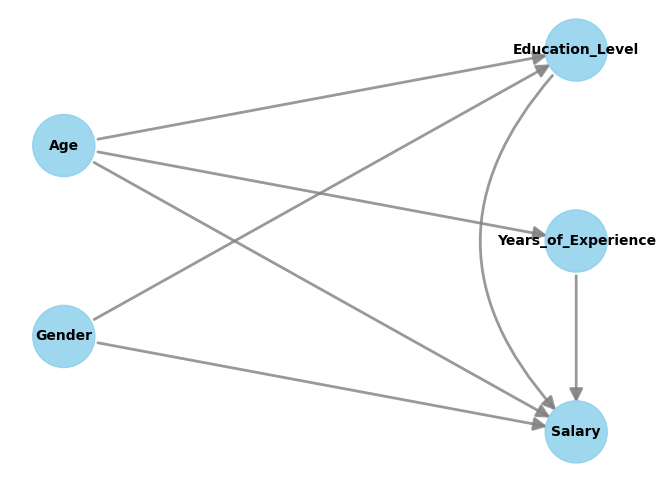

In [12]:
from dowhy import CausalModel
model= CausalModel(
        data = df,
        graph=causal_graph.replace("\n", " "),
        treatment='Education_Level',
        outcome='Salary')

model.view_model()

# causal identification

In [14]:
estimands = model.identify_effect()
print(estimands)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                               
──────────────────(E[Salary|Gender,Age])
d[Education_Level]                      
Estimand assumption 1, Unconfoundedness: If U→{Education_Level} and U→Salary then P(Salary|Education_Level,Gender,Age,U) = P(Salary|Education_Level,Gender,Age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



The `identify_effect` function from DoWhy is used to determine which causal estimands can be identified given the assumptions and the model structure. Here's a breakdown of the results you provided:

## Estimand Expression:

$
\frac{d}{𝑑[Education Level]}
(
E[Salary | Gender, Age]
)
$

This formula represents the average treatment effect (ATE) of $Education_Level$ on $Salary$ while controlling for $Gender$ and $Age$ to account for confounding factors. 

The backdoor method involves controlling for variables (here, $Gender$ and $Age$) that could confound the relationship between the treatment ($Education_Level$) and the outcome ($Salary$).

## Unconfoundedness: 

This assumption states that any unobserved variables affecting both $Education\_Level$ and $Salary$ are not affecting the relationship between these variables once we control for $Gender$ and $Age$. 

Mathematically, it means that if there are unobserved variables 
$𝑈$, 
such that 

$U→\{Education\_Level\}$

 and 

$U→Salary$, 

then the conditional distribution of Salary given $Education\_Level$, $Gender$, and $Age$ is the same whether or not we include 
$U$:

$P(Salary∣Education Level,Gender,Age,U)=P(Salary∣Education Level,Gender,Age)$

## Estimand : 2 (Instrumental Variables - IV)

Estimand Name: iv

Variable Availability: No such variable(s) found.

This suggests that no variables in your model satisfy the requirements for an instrumental variable analysis.

Instrumental variables are typically used when there is concern about endogeneity or when some variables are not exogenous.

## Estimand : 3 (Frontdoor)

Estimand Name: frontdoor

Variable Availability: No such variable(s) found.
    
The frontdoor criterion involves finding a variable that mediates the effect of the treatment on the outcome.

In your case, it seems there are no variables in your model that satisfy this criterion for identifying causal effects through the frontdoor method.

# linear_regression effect estimation

In [17]:
estimate= model.estimate_effect(
identified_estimand=estimands,
method_name='backdoor.linear_regression',
confidence_intervals=True,
test_significance=True
)

print(f'Estimate of causal effect: {estimate}')

Estimate of causal effect: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                               
──────────────────(E[Salary|Gender,Age])
d[Education_Level]                      
Estimand assumption 1, Unconfoundedness: If U→{Education_Level} and U→Salary then P(Salary|Education_Level,Gender,Age,U) = P(Salary|Education_Level,Gender,Age)

## Realized estimand
b: Salary~Education_Level+Gender+Age+Education_Level*Years_of_Experience
Target units: 

## Estimate
Mean value: 29089.154379444575
p-value: [3.19478926e-59]
95.0% confidence interval: (25574.717986810618, 32575.70416286758)
### Conditional Estimates
__categorical__Years_of_Experience
(-0.001, 3.0]    41967.753755
(3.0, 5.0]       36703.199304
(5.0, 8.0]       31387.761831
(8.0, 13.0]      23417.492346
(13.0, 34.0]      8683.994041
dtype: float64


## Identified Estimand:

### Estimand Type: NONPARAMETRIC_ATE (Average Treatment Effect).

### Estimand Name: backdoor.

### Expression: 

$\frac{𝑑}{𝑑
[
Education Level
]}
(
E[Salary | Age, Gender]
)
$

This formula represents the average effect of changes in `Education_Level` on `Salary`, while controlling for `Age` and `Gender`.

## Assumption:

### Unconfoundedness: 

The assumption states that any unobserved confounders affecting `Education_Level` should also affect `Salary`, so the relationship between `Salary` and `Education_Level` (controlling for `Age` and `Gender`) is not biased by omitted variables.

## Realized Estimand

Model Specification: The model used for the estimate is 

`
Salary
∼
Education Level
+
Age
+
Gender
+
Education Level
×
Years of Experience
`
    
This suggests that the model includes not only the main effects but also the interaction between `Education Level` and `Years of Experience`.

## Estimate

### Mean Value: 

The average estimated causal effect of `Education_Level` on `Salary` is approximately `$29,089.15`.

### Causal Effect: 

The mean value of `$29,089.15` suggests that, on average, a one-unit increase in `Education_Level` is associated with an increase of approximately `$29,089.15` in Salary, when controlling for `Age`, `Gender`, and the interaction between `Education_Level` and `Years of Experience`.

### Average Estimate: 

This value is the overall average effect across the population in your study, considering the entire range of `Years of Experience` and other covariates included in your model. It reflects the average impact of educational attainment on salary within the context of the model’s assumptions and the specific dataset you are analyzing.

## p-value: 

$
3.19478926
\times 10^{−59}
$
 , which is extremely small and indicates a highly significant result.

## 95% Confidence Interval: 

`(25,974.24, 31,996.43)`. This interval provides a range where the true effect is likely to lie with 95% confidence.

## Conditional Estimates

These estimates show the causal effect of `Education_Level` on `Salary` at different ranges of `Years_of_Experience`:

```
(-0.001, 3.0]: $41,967.75
(3.0, 5.0]: $36,703.20
(5.0, 8.0]: $31,387.76
(8.0, 13.0]: $23,417.49
(13.0, 34.0]: $8,683.99
```

These values suggest that the effect of `Education_Level` on `Salary` decreases as `Years_of_Experience` increases. For individuals with fewer years of experience, the effect of `Education_Level` on `salary` is higher compared to those with more experience.

# propensity_score_stratification

In [22]:
%%time

estimate= model.estimate_effect(
identified_estimand=estimands,
method_name='backdoor.propensity_score_stratification',
confidence_intervals=True,
test_significance=True
)

print(f'Estimate of causal effect: {estimate}')

Estimate of causal effect: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                               
──────────────────(E[Salary|Gender,Age])
d[Education_Level]                      
Estimand assumption 1, Unconfoundedness: If U→{Education_Level} and U→Salary then P(Salary|Education_Level,Gender,Age,U) = P(Salary|Education_Level,Gender,Age)

## Realized estimand
b: Salary~Education_Level+Gender+Age
Target units: ate

## Estimate
Mean value: 23098.97394938504
p-value: [0, 0.001]
95.0% confidence interval: (18865.401986502133, 26017.464620431812)

CPU times: total: 3min 39s
Wall time: 5min 34s


In [46]:
refutel_common_cause=model.refute_estimate(estimands,estimate,"random_common_cause")
print(refutel_common_cause)

Refute: Add a random common cause
Estimated effect:29089.154379444575
New effect:29087.742321821734
p value:0.94



# end